In [1]:
import pandas as pd
import numpy as np

import time
import sys
from tqdm.notebook import tqdm
import gc

pd.set_option('display.max_colwidth', -1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


In [2]:
path_data = "/Users/yohannlefaou/Documents/data/posos/"

In [3]:
train = pd.read_csv(path_data +"input_train.csv", sep=",")
print(train.shape)

(8028, 2)


In [4]:
labels = pd.read_csv(path_data + "output_train.csv", sep=",")

In [5]:
train.head(20)

,ID,question
0,0,"bonjour, je m suis trompé de forum pour ma question alors je la repose ici. je pris pour la première fois hier du paroxétine et ce matin c'est une catastrophe. picotement dasn tous le corps annonciateur de sueur froide très très massive et de vomissement. j'en suis à deux crises depuis 5 heure du mat. la cela semble passer mes mes mains reste moites et chaude estce normal pour la première fois merci a tous"
1,1,est ce que le motilium me soulagera contre les nausées?
2,2,"mon médecin m'a prescrit adenyl. au 2ème cachet des maux de tête terribles et au 3ème palpitations, sueurs froides, chaleur intense dans la tête, tremblements, fourmillements dans la lèvre supérieure, difficultés à respirer.. dès l'arrêt du médicament tous les symptômes ont disparu. cela est-il déjà arrivé à quelqu'un??"
3,3,Est-ce qu'il existe une forme adaptée aux enfant de 5ans du Micropakine ?
4,4,mon medecin me soigne pour une rhino pharingite et m'a prescrit du amoxicilline comme anti biotique. Est-ce vraiment pour cette indication?
5,5,je viens d'apprendre que je suis enceinte..savez-vous si je peux poursuivre le rubozinc ?
6,6,atrax n'est-il pas dangereux au long terme ?
7,7,je suis sous mercilon. J'ai des nausées et des saignements ?
8,8,"L'atenolol, c'est quoi ?"
9,9,"je prend trinordiol et à la fin de ma première plaquette j'ai eu ma première fois ac mn copain. la pilule est donc bien efficace dès le debut ? j'ai des douleur dans la poitrine, j'ai l'impression qu'ils ont un peu grossi ossi de plus, j'ai mal o bas du ventr,e dois je minkiété ou c simplemen, la periode dadaptation ??"


In [6]:
labels.head(20)

,ID,intention
0,0,28
1,1,31
2,2,28
3,3,44
4,4,31
5,5,44
6,6,48
7,7,28
8,8,22
9,9,23


In [7]:
labels["intention"].value_counts()

28    1796
31    565 
44    560 
22    461 
48    387 
34    382 
32    321 
14    317 
42    315 
23    208 
0     204 
11    195 
21    180 
33    144 
8     134 
37    126 
38    120 
13    119 
27    104 
5     102 
43    91  
12    89  
47    82  
29    77  
4     76  
26    72  
10    68  
24    64  
9     54  
30    52  
35    50  
45    50  
41    45  
46    45  
39    40  
50    33  
25    30  
6     26  
36    25  
15    23  
1     23  
18    23  
2     22  
49    22  
7     20  
19    20  
20    19  
16    17  
17    15  
3     8   
40    7   
Name: intention, dtype: int64

In [8]:
list_stop_words_fr = []
with open('stop-words-fr.txt', 'r') as f:
    for line in f.readlines():
        list_stop_words_fr.append(line.rstrip('\n'))

In [9]:
list_stop_words_fr

['a',
 'abord',
 'absolument',
 'afin',
 'ah',
 'ai',
 'aie',
 'aient',
 'aies',
 'ainsi',
 'ait',
 'allaient',
 'allo',
 'allons',
 'allô',
 'alors',
 'as',
 'assez',
 'au',
 'aupres',
 'auquel',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'aussi',
 'autre',
 'autrefois',
 'autrement',
 'autres',
 'autrui',
 'aux',
 'auxquelles',
 'auxquels',
 'avaient',
 'avais',
 'avait',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayez',
 'ayons',
 'b',
 'bah',
 'bas',
 'basee',
 'bat',
 'bien',
 'bigre',
 'bon',
 'boum',
 'bravo',
 'brrr',
 'c',
 'car',
 'ce',
 'ceci',
 'cela',
 'celle',
 'celle-ci',
 'celle-là',
 'celles',
 'celles-ci',
 'celles-là',
 'celui',
 'celui-ci',
 'celui-là',
 'celà',
 'cent',
 'cependant',
 'certain',
 'certaine',
 'certaines',
 'certains',
 'certes',
 'ces',
 'cet',
 'cette',
 'ceux',
 'ceux-ci',
 'ceux-là',
 'chacun',
 'chacune',
 'chaque',
 'cher',
 'chers',
 'chez',
 'chic

In [20]:
tfidf1 = TfidfVectorizer(sublinear_tf=False,
                         min_df=3,
                        ngram_range=(1, 3), # (1, 2), elliot faisait 1 a 5 grams lui, + Tf-idf sur les characters
                        stop_words=list_stop_words_fr,
                        strip_accents="unicode",
                        lowercase=True,)


In [21]:
features_tfidf1 = tfidf1.fit_transform(train["question"]).toarray()

/Users/yohannlefaou/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'chere', 'cheres', 'cinquantieme', 'cinquieme', 'dela', 'deuxieme', 'deuxiemement', 'dixieme', 'douzieme', 'etaient', 'etais', 'etait', 'etat', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'he', 'hola', 'huitieme', 'meme', 'memes', 'neuvieme', 'notres', 'ohe', 'ole', 'olle', 'onzieme', 'plutot', 'quatrieme', 'quatriemement', 'quelqu', 'revoila', 'septieme', 'sixieme', 'troisieme', 'troisiemement', 've', 'voila', 'votres'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [22]:
features_tfidf1.shape

(8028, 6136)

In [321]:
# add cosine similarity features
# for each questions, we compute the similarities with each class
# to do so, for a given class, we do the average of the similarities with all the questions of the class
# (using leave one out approach)
# this improve the accuracy score of the random forest by 0.1
from sklearn.metrics.pairwise import cosine_similarity

In [322]:
list_similarities = []
for i in tqdm(range(len(labels))):
    similarities = cosine_similarity(np.delete(features, obj=i, axis=0), features[i].reshape(1, -1))
    df_similarities = pd.DataFrame({"class": labels["intention"].drop(index=i, axis=0).values,
                                    "similarity": similarities[:,0]})
    class_similarities = df_similarities.groupby("class")["similarity"].mean()
    list_similarities.append(class_similarities)

In [323]:
df_similarity_features1 = pd.DataFrame(list_similarities)

In [324]:
df_similarity_features1.head()

class,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
similarity,0.003805,0.000000,0.000000,0.0,0.000628,0.003590,0.000000,0.006081,0.000939,0.000875,...,0.015519,0.004961,0.002613,0.003611,0.002518,0.003203,0.006982,0.011482,0.003508,0.000000
similarity,0.000451,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000362,0.000000,0.001813,0.013389,0.000000,0.000000,0.002101,0.000000,0.000000
similarity,0.008940,0.003756,0.000000,0.0,0.004321,0.002538,0.000000,0.000000,0.009363,0.017346,...,0.000742,0.005149,0.002930,0.003754,0.006788,0.005306,0.007533,0.005900,0.001422,0.001282
similarity,0.008886,0.018919,0.009587,0.0,0.000000,0.001880,0.021782,0.008984,0.004116,0.003169,...,0.000000,0.012514,0.004318,0.017599,0.019347,0.000000,0.000000,0.001650,0.000000,0.009630
similarity,0.007183,0.003935,0.000000,0.0,0.015257,0.002971,0.002663,0.017241,0.013460,0.020901,...,0.000000,0.007442,0.017103,0.006202,0.005364,0.003176,0.015592,0.005003,0.000000,0.002470


In [325]:
accuracy_score(labels["intention"].values,
               np.argmax(np.array(df_similarity_features1), axis=1)) #voir si ça marche

0.3237419033383159

In [24]:
# Finding the three most correlated terms with each of the product categories
N = 3
for label in range(51):
    features_chi2 = chi2(features_tfidf1, labels["intention"] == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf1.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    #quatregrams = [v for v in feature_names if len(v.split(' ')) == 4]
    #cinqgrams = [v for v in feature_names if len(v.split(' ')) == 5]

    print("\n==> label %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(trigrams[-N:])))
    #print("  * Most Correlated Bigrams are: %s" %(', '.join(quatregrams[-N:])))
    #print("  * Most Correlated Bigrams are: %s" %(', '.join(cinqgrams[-N:])))
    


==> label 0:
  * Most Correlated Unigrams are: equivalent, alternative, remplacer
  * Most Correlated Bigrams are: remplacer contramal, alternative therapeutique, quelle alternative
  * Most Correlated Bigrams are: seroplex depuis semaines, methadone remplacer contramal, quelle alternative therapeutique

==> label 1:
  * Most Correlated Unigrams are: memantine, veratran, remicad
  * Most Correlated Bigrams are: mois apres, quels symptomes, quels problemes
  * Most Correlated Bigrams are: quels effets secondaires, quels effets indesirables, quelle forme galenique

==> label 2:
  * Most Correlated Unigrams are: sanguin, biologique, bilan
  * Most Correlated Bigrams are: bilan sanguin, avant instauration, quel bilan
  * Most Correlated Bigrams are: combien temps faut, combien temps apres, temps faut attendre

==> label 3:
  * Most Correlated Unigrams are: pourquoi, manque, fabricant
  * Most Correlated Bigrams are: rupture stock, quelle etait, manque fabricant
  * Most Correlated Bigrams


==> label 32:
  * Most Correlated Unigrams are: varicelle, conseillez, solution
  * Most Correlated Bigrams are: quel medicament, vaccin varicelle, quel traitement
  * Most Correlated Bigrams are: crise angoisse solutions, quel vaccin contre, vaccin contre varicelle

==> label 33:
  * Most Correlated Unigrams are: soleil, boire, alcool
  * Most Correlated Bigrams are: consommer alcool, boire alcool, avec alcool
  * Most Correlated Bigrams are: desobel ge 20, jours plus tard, compatible avec millepertuis

==> label 34:
  * Most Correlated Unigrams are: association, interaction, associer
  * Most Correlated Bigrams are: interaction entre, skenan doliprane, meme temps
  * Most Correlated Bigrams are: melanger solupred ibuprofen, homeopathie huile essentielle, meme temps effexor

==> label 35:
  * Most Correlated Unigrams are: eau, smecta, administrer
  * Most Correlated Bigrams are: subutex lieu, comment prendre, comment administrer
  * Most Correlated Bigrams are: pose sterilet cuivre, 

In [39]:
tfidf2 = TfidfVectorizer(sublinear_tf=False,
                         min_df=10,
                         analyzer = "char",
                         ngram_range=(2, 7),
                         strip_accents="unicode",
                         lowercase=True,)


In [40]:
features_tfidf2 = tfidf2.fit_transform(train["question"]).toarray()

In [41]:
features_tfidf2.shape

(8028, 49288)

In [23]:
# other features
# voir si autres features intéressant !

def count_words(s):
    return len(s.split())

df_engineered_features = pd.DataFrame({"count_characters" : train["question"].apply(len).values,
                                       "count_words" : train["question"].apply(count_words).values})



# Model

## Random Forest

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(np.concatenate([features_tfidf1
                                                                      #, np.array(df_similarity_features)
                                                                      #, np.array(df_engineered_features)
                                                                     ], axis=1),
                                                      labels["intention"].values, test_size=0.2,
                                                      random_state=2019)

In [28]:
## Random forest

rf = RandomForestClassifier(max_depth = 30, n_estimators=100) # , max_features=None 

In [29]:
%%time
rf.fit(X_train, y_train)

CPU times: user 14.7 s, sys: 172 ms, total: 14.9 s
Wall time: 15.2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
accuracy_score(y_valid, rf.predict(X_valid))

0.43586550435865506

In [360]:
pd.DataFrame({"var": ["tf_idf_feat_" + str(i) for i in range(features.shape[1])] \
              + ["tf_idf_sim_" + str(i) for i in range(df_similarity_features.shape[1])]#+ \
              #list(df_engineered_features.columns)
              , "imp":rf.feature_importances_}).sort_values("imp", ascending=False).head(50)
                      
                      
                      

,var,imp
2516,tf_idf_sim_28,0.035189
2532,tf_idf_sim_44,0.029256
2536,tf_idf_sim_48,0.026044
2519,tf_idf_sim_31,0.021188
2499,tf_idf_sim_11,0.020096
2509,tf_idf_sim_21,0.019489
2530,tf_idf_sim_42,0.019197
2520,tf_idf_sim_32,0.019158
2510,tf_idf_sim_22,0.018501
2522,tf_idf_sim_34,0.018021


# Neural network

In [42]:
from sklearn.preprocessing import OneHotEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


In [43]:
# preprocessing
# one hot encode the target
ohe = OneHotEncoder()
one_hot_encode_labels = ohe.fit_transform(labels["intention"].values.reshape(-1, 1)).toarray()

/Users/yohannlefaou/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(np.concatenate([#features_tfidf1,
                                                                      #, np.array(df_similarity_features)
                                                                      #, np.array(df_engineered_features)
                                                                      features_tfidf2
], axis=1),
                                                      one_hot_encode_labels,
                                                      test_size=0.2,
                                                      random_state=2019)

In [45]:
nn = Sequential()
nn.add(Dropout(0.5, input_shape=(X_train.shape[1],)))
#nn.add(Dense(1024, activation="relu")) # input_dim= 768
#nn.add(Dropout(0.2))
nn.add(Dense(256, activation="relu"))
#nn.add(Dropout(0.2))
nn.add(Dense(51, activation="softmax")) #a completer

nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

nn.fit(np.array(X_train), y_train, epochs=30, batch_size=10,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) #, callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/30
6422/6422 [==============================] - 237s 37ms/step - loss: 2.1920 - accuracy: 0.4785 - val_loss: 1.4464 - val_accuracy: 0.6314
Epoch 2/30
6422/6422 [==============================] - 204s 32ms/step - loss: 0.7936 - accuracy: 0.8026 - val_loss: 1.1680 - val_accuracy: 0.6930
Epoch 3/30
6422/6422 [==============================] - 191s 30ms/step - loss: 0.2961 - accuracy: 0.9340 - val_loss: 1.1537 - val_accuracy: 0.7042
Epoch 4/30
6422/6422 [==============================] - 186s 29ms/step - loss: 0.1332 - accuracy: 0.9749 - val_loss: 1.2081 - val_accuracy: 0.6949
Epoch 5/30
 100/6422 [..............................] - ETA: 3:02 - loss: 0.0321 - accuracy: 1.0000

KeyboardInterrupt: 

In [380]:
nn.fit(np.array(X_train), y_train, epochs=5, batch_size=256,
       validation_data=(np.array(X_valid), y_valid), shuffle=True) #, callbacks=[es]

Train on 6422 samples, validate on 1606 samples
Epoch 1/5
6422/6422 [==============================] - 2s 280us/step - loss: 0.9382 - accuracy: 0.7191 - val_loss: 1.4268 - val_accuracy: 0.6308
Epoch 2/5
6422/6422 [==============================] - 2s 262us/step - loss: 0.9139 - accuracy: 0.7239 - val_loss: 1.4210 - val_accuracy: 0.6314
Epoch 3/5
6422/6422 [==============================] - 2s 273us/step - loss: 0.9126 - accuracy: 0.7222 - val_loss: 1.4216 - val_accuracy: 0.6308
Epoch 4/5
6422/6422 [==============================] - 2s 274us/step - loss: 0.8981 - accuracy: 0.7278 - val_loss: 1.4206 - val_accuracy: 0.6308
Epoch 5/5
6422/6422 [==============================] - 2s 278us/step - loss: 0.9029 - accuracy: 0.7317 - val_loss: 1.4202 - val_accuracy: 0.6308


In [276]:
np.set_printoptions(threshold=sys.maxsize)

In [285]:
cm = confusion_matrix(np.argmax(nn.predict(np.array(X_valid)), axis=1), np.argmax(y_valid, axis=1))

In [283]:
count_predictions = np.sum(cm, axis=1)
count_predictions[count_predictions == 0] = 1

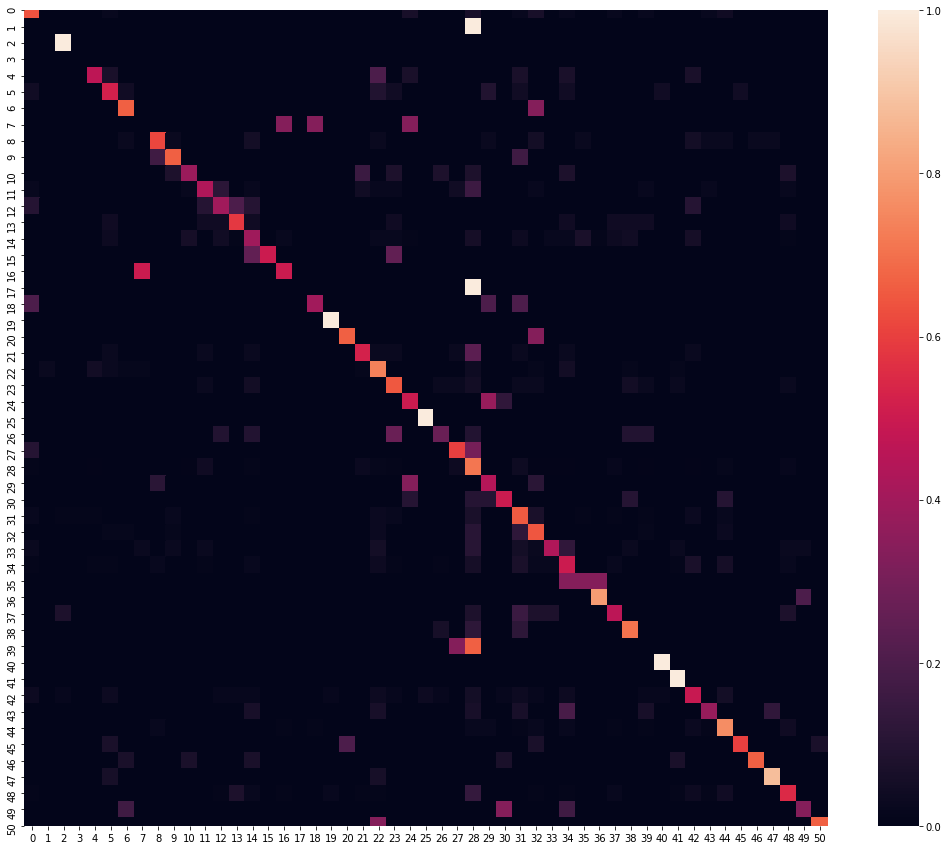

In [293]:
# we represent the precisions of the models
import seaborn as sns
fig=plt.figure(figsize=(18, 15))
sns.heatmap(cm / count_predictions[:, None])

In [308]:
pd.DataFrame({"class": list(range(51)), "precision":np.diag(cm / count_predictions[:, None])} )

,class,precision
0,0,0.638298
1,1,0.000000
2,2,1.000000
3,3,0.000000
4,4,0.466667
5,5,0.521739
6,6,0.666667
7,7,0.000000
8,8,0.615385
9,9,0.666667
